# FORESEE - ALP light shining through the wall

### Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import os
import random
import math
from skhep.math.vectors import LorentzVector, Vector3D

#src_path = "/Users/felixkling/Documents/GitHub/FORESEE/"
src_path = "/Users/abraham/Documents/GitHub/roshanFORESEE/"

sys.path.append(src_path)
from src.foresee import Foresee, Utility, Model

/Users/abraham/Documents/GitHub/roshanFORESEE/src/foresee.py:597: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def boostlist(arr_particle, arr_boost):


## 1. Initialization 

All function that we will need are included in the FORESEE package. We start by simply initializing it: 

In [3]:
foresee = Foresee(path=src_path)

The ALP is mainly produced via the coherent photon to ALP conversion in the LHC magnetic fields. To start, let us have a look at the photon spectrum in terms of the angle with respect to the beam axis $\theta$ and the momentum $p$. This can be done using the function `get_spectrumplot` which requires the MC particle ID (or simply pid), the MC generator and the energy. The units on the coloraxis are pb/bin. 

FORESEE provides the 2D spectrum as tables for a variety of particles ($\pi^0$, $\eta$, ...), generators (SIBYLL, EPOSLHC, QGSJET, PYTHIA) and collision energies (14, 27 and 100 TeV). The datafiles are stored in the directory `files/hadrons`. 

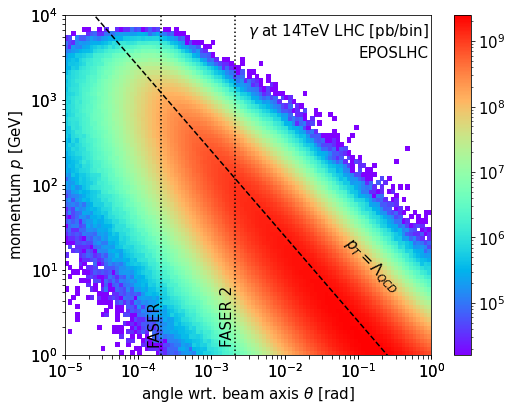

In [3]:
foresee = Foresee(path=src_path)
plot=foresee.get_spectrumplot(pid="22", generator="EPOSLHC", energy="14", prange=[[-5, 0, 100],[ 0, 4, 80]])
plot.text(-2.5,3.75, r"$\gamma$ at 14TeV LHC [pb/bin]",fontsize=15,color="k",rotation=0)
plot.text(-1,3.5, r"EPOSLHC",fontsize=15,color="k",rotation=0)
plot.plot(np.linspace(0,-5,50), [np.log10(0.25)-lt for lt in np.linspace(0,-5,50)], ls="dashed", c="k")
plot.text(-1.25,0.75, r"$p_T=\Lambda_{QCD}$",fontsize=15,color="k",rotation=-45)
plot.plot([np.log10(.1/480.),np.log10(.1/480.)], [0,4], c='k', ls="dotted")
plot.text(-3.88,0.1, r"FASER",fontsize=15,color="k",rotation=90,ha="left",va="bottom")
plot.plot([np.log10(1./480.),np.log10(1./480.)], [0,4], c='k', ls="dotted")
plot.text(-2.88,0.1, r"FASER 2",fontsize=15,color="k",rotation=90,ha="left",va="bottom")
plot.subplots_adjust(left=0.12, right=1.03, bottom=0.11, top=0.97)
plot.savefig("/Users/felixkling/Downloads/Photons.pdf")
plot.show()

## 2. Model and Setup

**Model:** The phenomenology of the ALP can be described by the following Lagrangian

\begin{equation}
 \mathcal{L} = - \frac{1}{2} m_{a}^2 a^2  - \frac{g}{4}a F^a_{\mu\nu} \tilde F^a_{\mu\nu}
\end{equation}

with the ALP mass $a$ and the coupling parameter $g$ as free parameters. 

**Process:** Unlike most other physics models at FASER, here we are not the decay of an ALP inside the FASER decay volume but its conversion in FASER's magnetic field. For this, let us note that we can rewrite the ALP coupling as $a F^a_{\mu\nu} \tilde F^a_{\mu\nu} \sim a \vec{E} \cdot \vec{B}$, so as a coupling between the ALP, an electric field and a magnetic field. This means that in the presence of an external magnetic field a photon can convert into an ALP and vice versa. Her can use this effect twice: once to convert an LHC photon inside the forward LHC magnets  into an ALP, and once to convert the ALP back into a photon in inside the FASER magnet. The signature is therefore a single high-energy photon appearing inside the FASER detector.   

Since this process is very specific to this particular mode, we are directly providing the code below, and only rarely make use of the FORESEE functionaties. 

### 2a) Load Photons

First, let us load the LHC photons into a numpy array labeled `photons`. 

In [23]:
energy = "13.6"
generator=['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward']
modelname="ALP-LSW"

photons_list = []

for gen in generator:
    filename = foresee.dirpath + "files/hadrons/"+energy+"TeV/"+gen+"/"+gen+"_"+energy+"TeV_22.txt"
    photons_list.append(foresee.readfile(filename))

# photons = foresee.readfile(filename)

### 2b) Define Fields

Next, we define the magnetic fields. Here *dipole* magnets are defined by a constant magnetic field $B$ while *quadrupol* magnets are defined by a field gradient $B'$. For FASER, FASER2, the LHC and the HL-LHC we specify

- the type of magnet (`q` for quadrupole and `d` for dipole)
- the starting position `z` in meters
- the length `L` in meters
- the strength `B` in Tesla (for dipoles) or gradient `B'` in Tesla/meter (for quadrupoles)

The LHC configuration is taken from Ref. [2105.08270](https://arxiv.org/abs/2105.08270), while the HL-LHC configuration is taken from [HL-LHC TDR](https://cds.cern.ch/record/2749422/) 

In [5]:
magnets = {
    "FASER": [
        ["d", 0   , 1.5 , 0.6  ],
        ["d", 1.7 , 1.0 , 0.6  ],
        ["d", 2.9 , 1.0 , 0.6  ],
    ],
    "FASER2": [
        ["d", 0   , 20  , 1    ],
    ],
    "LHC": [
        ["q", 22.9, 6.37, 188.6],
        ["d", 30. , 1   , 1.5  ],
        ["q", 32  , 5.5 , 191. ],
        ["d", 38. , 1   , 1.5  ],
        ["q", 39  , 5.5 , 191  ],
        ["q", 46.9, 6.37, 188.6],
        ["d", 53.5, 1   , 1.5  ],
        ["d", 60. , 20. , 1.28 ],
    ],
    "HLLHC": [
        ["q", 22.9, 8.4 ,132. ],
        ["d", 34  , 1.  ,2.5  ],
        ["q", 35  , 7.17,132. ],
        ["q", 45  , 7.17,132. ],
        ["d", 53  , 1   ,2.5  ],
        ["q", 56. , 8.4 ,132. ],
        ["d", 68  , 1   ,4.5  ],
        ["d", 72. , 6.27,5.6  ],
    ],
}

### c) Simple back-on-the envelope estimate

We can already perform a vary simple back-on-the envelope estimate by only using the D1 magnet (which provides the dominant contribution) and assuming the small mass limit (so $qL\ll1$). The function below provides the coupling reach requireing 3 signal events. For this we need: 
- the number of photons `n0`
- the B-field of the D1 magnet `b1`
- the length of the D1 magnet `l1`
- the B-field of the FASER magnet `b2`
- the length of the FASER magnet `l2`

In [6]:
def back_on_envelope_estimate(n0=2e15, b1=1.28, l1=20, b2=0.6, l2=3.5):
    nevent =  n0 * 10 * b1**2 * b2**2 * l1**2 * l2**2
    return (3./nevent)**(0.25)

print ("The LHC reach is g="   +str( back_on_envelope_estimate(n0=2e15, b1=1.28, l1=20  , b2=0.6, l2=3.5)))
print ("The HL-LHC reach is g="+str( back_on_envelope_estimate(n0=6e17, b1=5.6 , l1=6.27, b2=1  , l2=20 )))

The LHC reach is g=1.5093612104957631e-05
The HL-LHC reach is g=1.0034592006537216e-06


### d) Production and Detection Probabilities

The conversion probability in a magnetic field has been derived in [2203.06137](https://arxiv.org/abs/2203.06137). For **axion to photon converison** we can write

\begin{equation}
P(a \to \gamma) = \frac{1}{4} g^2 \left| \int dz \ B(x) \ e^{i q z} \right|^2 = \frac{1}{4} g^2 B^2 L^2 \left(\frac{\sin(qL/2)}{qL/2}\right)^2
\end{equation}

Here we explicitly used that the FASER magnets are homogeneous, which results in linearly polarized photons in the detector. For **photon to axion converison** it is given by

\begin{equation}
P(\gamma \to a) = \frac{1}{n_\text{pol} }\sum_\text{pol}\frac{1}{4} g^2 \left| \int dz \ e^{i q z} \ \vec{B}(z)\cdot  \vec{p}   \right|^2 = \frac{g^2}{8}  \left( \left| \int dz \ B_x(z) \ e^{i q z} \right|^2 + \left| \int dz \ B_y(z)  \ e^{i q z} \right|^2 \right) 
\end{equation}

Here $p$ denotes the polarization vectors, which we have written in terms of a linear polariztaion basis. To simplify the expression we can use that the fields are (to a good approximation) piecewise constant along the trajectory of a photon and therefore write

\begin{equation}
 \int dz B(z) e^{i q z}  =  \sum_i B_i \times \left[ \frac{e^{iqz}}{iq} \right]^{z_i+L_i}_{z_i} =   \sum_i B_i \times \frac{e^{iq(z_i+L_i)}-e^{iqz_i}}{iq} =   \sum_i B_i L_i \times e^{iq(z_i+L_i/2)}\frac{e^{iqL_i/2}-e^{-iqL_i/2}}{2i qL_i/2} = \sum_i B_i L_i \times e^{iq(z_i+L_i/2)}\frac{\sin(q L_i /2)}{qL_i/2} 
\end{equation}

So we can write 

\begin{equation}
P(\gamma \to a) = \frac{g^2}{8}  \left( \left|  \sum_i B_{x,i} L_i \times e^{iq(z_i+L_i/2)}\frac{\sin(q L_i /2)}{qL_i/2}  \right|^2 + \left|  \sum_i B_{y,i} L_i \times e^{iq(z_i+L_i/2)}\frac{\sin(q L_i /2)}{qL_i/2}  \right|^2 \right) 
\end{equation}

In addition, we can use also the **Primakoff conversion in production**. Following [1806.02348](https://arxiv.org/abs/1806.02348) and for very small $m_a$, we get

\begin{equation}
P(\gamma \to a)_{Prim} = \sigma_{Prim}/\sigma_{SM} = 0.000737 \times g^2 \quad \text{where} \quad \sigma_{Prim} = \frac{1}{4} g^2 \alpha Z^2 \times \frac12 \int F^2(t)  d\log t
\end{equation}

Below we provide the exact Primakoff conversion probability factor as `get_conversion_factor()` function. 

In [7]:
def get_conversion_factor(tmin=1e-20):
    if tmin < 1e-12: return 0.00073736306
    alpha, me, ZFe, AFe = 1./137., 0.000511, 26, 56
    a, d  = 111.*ZFe**(-1./3.) / me,  0.164 * AFe**(-2./3.)
    SMXSinIGeV2 = 13311.9696379 
    logtmin, logtmax, nlogt = np.log10(tmin), 0, 20
    dlogt = (logtmax-logtmin)/float(nlogt)
    xs=0
    for lt in np.linspace(logtmin+0.5*dlogt,logtmax-0.5*dlogt,nlogt):
        t = 10**lt
        if t<7.39*me*me: ff = a*a*t/(1.+a*a*t)
        else: ff = 1./(1.+t/d)
        xs += alpha * ZFe**2 / 4. * 0.5 * ff**2  * dlogt * np.log(10) 
    return xs / SMXSinIGeV2 

print (get_conversion_factor(tmin=0.00000000001))

0.0007373183813658107


We could also have $a \to \gamma$ conversion via the **inverse Primakoff process** occuring inside a medium (so axion scattering). The probability is given by $P(a \to \gamma)_{Prim} = 1/(\sigma_{prim} n L) = 0.03 \times g^2$ for a 7m long LAr detector. Below, we provide a function that estimates the conversion probability in FLArE

In [8]:
def get_interaction_flare(tmin=1e-15, tmax=1):
    #shortcut
    if tmin<1e-12: return 0.02837736181362896
    #matter properties
    ZFe, AFe, rhoFe, lenFe = 18, 40, 1.4, 700 #FLArE LAr
    #get xs in cm2
    mproton = 1.6726219e-24 # grams
    alpha, me = 1./137., 0.000511
    a, d  = 111.*ZFe**(-1./3.) / me,  0.164 * AFe**(-2./3.)
    GeV_CM = 0.2e-13
    logtmin, logtmax, nlogt = np.log10(tmin), np.log10(tmax), 50
    dlogt = (logtmax-logtmin)/float(nlogt)
    xs=0
    for lt in np.linspace(logtmin+0.5*dlogt,logtmax-0.5*dlogt,nlogt):
        t = 10**lt
        if t<7.39*me*me: ff = a*a*t/(1.+a*a*t)
        else: ff = 1./(1.+t/d)
        xs += alpha * ZFe**2 / 4. * 0.5 * ff**2  * dlogt * np.log(10) 
    xscm2 = xs * GeV_CM**2 
    # number density
    ndensity = rhoFe / (AFe*mproton)
    #get mean free path
    mfp = 1 / xscm2 / ndensity
    # probability
    prob = lenFe / mfp
    return prob

tmin = 1e-9**4/(2*1000**2)
print (get_interaction_flare(tmin=tmin))

0.02837736181362896


## 3. Event Rate

Now that we have all the ingredients, we can combine them and estimate the number of events in FASER. This is done by the function `get_nevent()` which returns set of couplings and the corresponding number of events. 

In [9]:
def get_nevent(mass, setup = "FASER", do_prim=1, do_conv=1, gvals = np.logspace(-6,0,30+1)):
    
    #decay width
    gamma = mass**3/(64*3.1415)
    ctau = 0.2e-15/gamma
    
    # constants:
    t_m_igev, m_gev, aperture = 3.5, 5e15, 0.0265
    
    # setup for 2022+2023
    if setup == "FASER":
        magnets_p, magnets_d = magnets["LHC"], magnets["FASER"]
        lumi, radius, distance = 60.*1000,  0.1,  476.    
#     if setup == "FASER":
#         magnets_p, magnets_d = magnets["LHC"], magnets["FASER"]
#         lumi, radius, distance = 150.*1000,  0.1,  480.
    if setup == "FASER2":
        magnets_p, magnets_d = magnets["HLLHC"], magnets["FASER2"]
        lumi, radius, distance = 3000.*1000,  1.,  620.
    if setup == "FLARE":
        magnets_p = magnets["HLLHC"]
        lumi, radius, distance = 3000.*1000, 0.56, 620.

    # loop over particles
    nvals = [0 for g in gvals]
    stat_t, stat_e, stat_w = [[] for g in gvals], [[] for g in gvals], [[] for g in gvals]
    for logt, logp, weight in photons:
        #kinematics
        th, en, phi = 10**logt, 10**logp, random.uniform(0, 2*math.pi) 
        q = mass**2/en 
        #remove large angle
        if th > radius / distance: continue
        
        #prob production
        integralx, integraly = 0, 0
        for mag, z, l, field in magnets_p:
            if z*th > aperture: continue
            if mag == "d": bx,by = 0, field
            else: bx, by = th * z * np.cos(phi) * field, th * z * np.sin(phi) * field
            ql=q*l*m_gev
            integralx += bx *  t_m_igev  * l * np.exp(-1.J*q*(z+l/2.)*m_gev)* np.sin(ql/2.)/(ql/2.) 
            integraly += by *  t_m_igev  * l * np.exp(-1.J*q*(z+l/2.)*m_gev)* np.sin(ql/2.)/(ql/2.) 
        prob_p= 1./8. *(abs(integralx)**2+abs(integraly)**2)
        # primakoff production
        prob_prim=0 if en<1 else get_conversion_factor(tmin=mass**4/(2*en**2) )
        
        #prob detection
        if setup != "FLARE":
            integral = 0
            for mag, z, l, field in magnets_d:
                if mag == "d": b = field
                else: continue
                ql=q*l*m_gev
                integral += b *  t_m_igev  * l * np.exp(-1.J*q*(z+l/2.)*m_gev)* np.sin(ql/2.)/(ql/2.) 
            prob_d = 1./4. *abs(integral)**2
        # primakoff detection
        if setup == "FLARE": 
            prob_d = get_interaction_flare(tmin=mass**4/(2*en**2) )
            
        # lifetime
        dbar = ctau*en/mass
        
        # count event rate
        dnevent = weight * lumi * (prob_p*do_conv+prob_prim*do_prim) * prob_d
        for ig, g in enumerate(gvals): 
            prob_notdecay = 1 if mass<1e-4 else np.exp(-(distance-140)/dbar*g**2)
            nvals[ig] += g**4 * dnevent * prob_notdecay   
            stat_t[ig].append(th)
            stat_e[ig].append(en)
            stat_w[ig].append(g**4 * dnevent * prob_notdecay)

    return gvals, nvals, stat_e, stat_w, stat_t

Let's look at an example for m=1eV: 

In [10]:
gs, ns, _, _, _ = get_nevent(mass=1e-9,  setup = "FASER",  gvals = np.logspace(-6,0,6+1))
for g,n in zip(gs, ns): print ("g="+str(g)+", n="+str(n))

g=1e-06, n=7.062471798938827e-05
g=1e-05, n=0.7062471798938831
g=0.0001, n=7062.471798938827
g=0.001, n=70624717.98938827
g=0.01, n=706247179893.8827
g=0.1, n=7062471798938831.0
g=1.0, n=7.062471798938829e+19


Let us now perform a parameter scan, and save the results

In [11]:
#define range
couplings, masses = np.logspace(-6, 0, 40+1), np.logspace(-15, 0, 60+1)

In [12]:
#FASER
setup, list_nevents = "FASER", []
for mass in masses:
    nevents = get_nevent(mass=mass,  setup=setup, gvals=couplings)[1]
    list_nevents.append(nevents)
np.save("model/results/"+energy+"TeV_"+setup+".npy",[masses*1e9,couplings,list_nevents])

NameError: name 'photons' is not defined

In [13]:
#FASER

generator=['EPOSLHC', 'SIBYLL', 'QGSJET', 'Pythia8-Forward']

for igen, gen in enumerate(generator):

    setup, list_nevents = "FASER", []
    photons = photons_list[igen]

    
    for mass in masses:
        nevents = get_nevent(mass=mass,  setup=setup, gvals=couplings)[1]
        list_nevents.append(nevents)
    np.save("model/results/"+energy+"TeV_"+setup+"_"+gen+".npy",[masses*1e9,couplings,list_nevents])

/Users/abraham/.pyenv/versions/3.10.5/lib/python3.10/site-packages/numpy/lib/npyio.py:501: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Finally, let's also save the contours. Here we can use the functionality provided by FORESEE. 

In [15]:
foresee.extract_contours(
    inputfile="model/results/14TeV_FASER.npy", 
    outputfile="model/lines/limits_FASER.txt",
    xlims=[1e-6,1e9],ylims=[10**-6,1],
)

foresee.extract_contours(
    inputfile="model/results/14TeV_FASER2.npy", 
    outputfile="model/lines/limits_FASER2.txt",
    xlims=[1e-6,1e9],ylims=[10**-6,1],
)

foresee.extract_contours(
    inputfile="model/results/14TeV_FLARE.npy", 
    outputfile="model/lines/limits_FLARE.txt",
    xlims=[1e-6,1e9],ylims=[10**-6,1],
)

## 4. Plot

In [15]:
model = Model("ALP-LSW")
foresee.set_model(model=model)

In [16]:
# setups = [
#     ["13.6TeV_FASER.npy",    "FASER "        , "firebrick"  ,  "solid"  , 0., 3],
# #     ["14TeV_FASER2.npy",   "FASER 2"       , "red"        ,  "solid"  , 0., 3],
# #     ["14TeV_FLARE.npy",    "FLARE"         , "orange"     ,  "solid"  , 0., 3],
# ]


setups = [ 
     ["13.6TeV_FASER_EPOSLHC.npy",  "EPOSLHC"    , "sienna"        ,  "solid"  , 0., 3],
     ["13.6TeV_FASER_SIBYLL.npy" ,  "SYBILL"  , "tomato"    ,  "dotted"  , 0., 3],
     ["13.6TeV_FASER_QGSJET.npy" ,"QGSJET", "maroon"     ,  "dashed"  , 0., 3],
     ["13.6TeV_FASER_Pythia8-Forward.npy" ,"Pythia8-Forward", "rosybrown"     ,  "dashdot"  , 0., 3],

]

Then we specify all the existing bounds (filename in model/bounds directory, label, label position x, label position y, label rotation). 

In [26]:
# bounds = [
#     ["bounds_Belle2.txt"  , ""                     , 0.210, 1.5*10**-3, 0 ],
#     ["bounds_PrimEx.txt"  , ""                     , 0.126, 1.2*10**-3, 0 ],
#     ["bounds_LEP.txt"     , "LEP"                  , 1e8  , 7.0e-3, 0 ],
#     ["bounds_BaBar.txt"   , "BaBar"                , 3e2  , 2e-4  , 0 ],
#     ["bounds_BeamDump.txt", "Beam\nDump"           , 2e6  , 1e-5  , 0 ],
#     ["bounds_Nomad.txt"   , "Nomad"                , 3e-2 , 2e-4  , 0 ],
#     ["bounds_PVLAS.txt"   , "PVLAS"                , 4e-3 , 2.0e-7, 0 ],
#     ["bounds_ALPS.txt"    , "ALPS"                 , 1e-5 , 9.0e-8, 0 ],
#     ["bounds_CROWS.txt"   , "CROWS"                , 2e-6 , 8.0e-4, 0 ],
#     ["bounds_Upsilon.txt" , r"BaBar $\Upsilon$"    , 0.126, 1.5e-3, 0 ],       
# ]

bounds = [
    ["bounds_Belle2.txt"  , ""                     , 0.210, 1.5*10**-3, 0 ],
    ["bounds_PrimEx.txt"  , ""                     , 0.126, 1.2*10**-3, 0 ],
    #["bounds_LEP.txt"     , "LEP"                  , 1e8  , 7.0e-3, 0 ],
    ["bounds_BaBar.txt"   , "BaBar"                , 4e2  , 2e-4  , 0 ],
    ["bounds_BeamDump.txt", "Beam\nDump"           , 2e4  , 6e-4  , 0 ],
    ["bounds_Nomad.txt"   , "Nomad"                , 3e-2 , 2e-4  , 0 ],
    ["bounds_PVLAS.txt"   , "PVLAS"                , 1e-2 , 7e-6, 0 ],
    ["bounds_ALPS.txt"    , "ALPS"                 , 1.1e-3 , 7e-6, 0 ],
    #["bounds_CROWS.txt"   , "CROWS"                , 2e-6 , 8.0e-4, 0 ],
    ["bounds_Upsilon.txt" , r"BaBar $\Upsilon$"    , 0.126, 1.5e-3, 0 ],       
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

In [27]:
projections = [
#    ["limits_FASER.txt",   "firebrick"    ,r"FASER"  , 0.004, 1.00*10**-4, 0  ],
#    ["limits_FASER2.txt",  "red"          ,r"FASER2" , 0.004, 3.00*10**-5, 0  ],
#    ["limits_FLARE.txt",   "orange"       ,r"FLARE"  , 0.004, 1.00*10**-5, 0  ],
]

We then specify other projected sensitivitities (filename in model/bounds directory, color, label, label position x, label position y, label rotation)

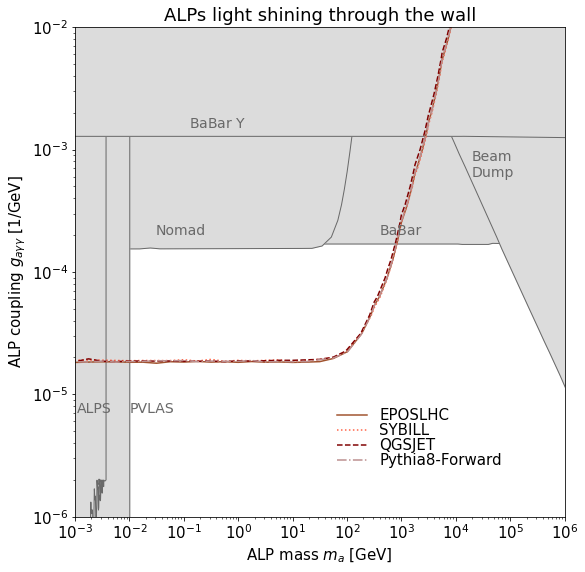

In [29]:
plot = foresee.plot_reach(
    setups=setups,
    bounds=bounds,
    projections=projections,
    title="ALPs light shining through the wall", 
#     xlims=[1e-6,1e+9], 
#     ylims=[1e-8,1e-2],
    xlims=[1e-3,1e+6], 
    ylims=[1e-6,1e-2],   
    xlabel=r"ALP mass $m_{a}$ [GeV]", 
    ylabel=r"ALP coupling $g_{a\gamma\gamma}$ [1/GeV]",
    legendloc=(0.90,0.25),
#    branchings=branchings,
    figsize=(8,8),
)

# QCD Axion Target Lines
# DFSZ = np.array([[0.00677, 1e-12], [31136768., 0.005]])
# plot.plot(DFSZ.T[0], DFSZ.T[1], color="k", lw=1.5, ls="dashed")        
# plot.text(5e2, 1e-7, "DFSZ",fontsize=13, color="k",rotation=68)
# KSVZ = np.array([[0.00277, 1e-12], [12761133., 0.005]])
# plot.plot(KSVZ.T[0], KSVZ.T[1], color="k", lw=1.5, ls="dashed")  
# plot.text(4.5e1, 1e-7, "KSVZ",fontsize=13, color="k",rotation=68)

plot.subplots_adjust(left=0.12, right=0.97, bottom=0.10, top=0.95)
#plot.savefig("/Users/felixkling/Downloads/Figure.pdf")
plot.savefig("figures/"+modelname+".pdf")
plot.show()

## 5. Export events as HEPMC file 

In analogy to the usual LLP decays, we provide a function that exports events as a HEPMC file. Below is the code:

In [23]:
def write_hepmc_file(data, filename):
        
        # open file
        f= open(filename,"w")
        f.write("HepMC::Version 2.06.09\n")
        f.write("HepMC::IO_GenEvent-START_EVENT_LISTING\n")
        
        # loop over events
        for ievent, (weight, position, momentum_alp, momentum_gamma) in enumerate(data):
            # Event Info
            # int: event number / int: number of multi paricle interactions [-1] / double: event scale [-1.] / double: alpha QCD [-1.] / double: alpha QED [-1.] / int: signal process id [0] / int: barcode for signal process vertex [-1] / int: number of vertices in this event [1] /  int: barcode for beam particle 1 [1] / int: barcode for beam particle 2 [0] /  int: number of entries in random state list (may be zero) [0] / long: optional list of random state integers [-] /  int: number of entries in weight list (may be zero) [0] / double: optional list of weights [-]
            f.write("E "+str(ievent)+" -1 -1. -1. -1. 0 -1 1 1 0 0 0\n")
            # int: number of entries in weight name list [0] /  std::string: list of weight names enclosed in quotes
            #f.write("N 1 \"Weight\" \n")
            # std::string: momentum units (MEV or GEV) [GeV] /  std::string: length units (MM or CM) [MM]
            f.write("U GEV MM\n")
            # double: cross section in pb /  double: error associated with this cross section in pb [0.]
            f.write("C "+str(weight)+" 0.\n")
            # PDF info - doesn't apply here
            f.write("F 0 0 0 0 0 0 0 0 0\n")
                
            #vertex
            f.write("V -1 0 ")
            f.write(str(round(position.x*1000,10))+" ")
            f.write(str(round(position.y*1000,10))+" ")
            f.write(str(round(position.z*1000,10))+" ")
            f.write(str(round(position.t*1000,10))+" ")
            f.write("1 1 0\n")
            
            # LLP
            f.write("P 1 32 ") # First particle, ID for Z'
            f.write(str(round(momentum_alp.px,10))+" ")
            f.write(str(round(momentum_alp.py,10))+" ")
            f.write(str(round(momentum_alp.pz,10))+" ")
            f.write(str(round(momentum_alp.e,10))+" ")
            f.write(str(round(momentum_alp.m,10))+" ")
            f.write("2 0 0 -1 0\n")

            #decay products
            f.write("P 2 22 ") 
            f.write(str(round(momentum_gamma.px,10))+" ")
            f.write(str(round(momentum_gamma.py,10))+" ")
            f.write(str(round(momentum_gamma.pz,10))+" ")
            f.write(str(round(momentum_gamma.e,10))+" ")
            f.write(str(round(momentum_gamma.m,10))+" ")
            f.write("1 0 0 0 0\n")
            
        # close file
        f.write("HepMC::IO_GenEvent-END_EVENT_LISTING\n")
        f.close()
           
def write_events(setup, mass, coupling, energy, filename=None, numberevent=10, zposition=0, nsample=1, seed=None, distance=480):
        
        #set random seed
        random.seed(seed)
        
        # get weighted sample of LLPs
        _,_, energies, weights, thetas = get_nevent(setup=setup, mass=mass, gvals = [coupling])
        weighted_raw_data = np.array([energies[0], thetas[0]]).T
        
        # unweight sample
        unweighted_raw_data = random.choices(weighted_raw_data, weights=weights[0], k=numberevent)
        eventweight = sum(weights[0])/float(numberevent)
        
        # get photon momenta and decay location
        unweighted_data = []
        for en, theta in unweighted_raw_data:
            # momentum
            phi= random.uniform(-math.pi,math.pi)
            pz, pt = en*np.cos(theta), en*np.sin(theta)
            px, py = pt*np.cos(phi)  , pt*np.sin(phi)
            momentum_gamma = LorentzVector(px,py,pz,en)
            # momentum
            mom = np.sqrt(en**2-mass**2)
            pz, pt = mom*np.cos(theta), mom*np.sin(theta)
            px, py = pt*np.cos(phi)  , pt*np.sin(phi)
            momentum_alp = LorentzVector(px,py,pz,en)
            # position
            posz = zposition
            posx = theta*distance*np.cos(phi)
            posy = theta*distance*np.sin(phi)
            position = LorentzVector(posx,posy,posz,0)
            # save
            unweighted_data.append([eventweight, position, momentum_alp, momentum_gamma])
        
        # set output filename
        dirname = "model/events/"
        if not os.path.exists(dirname): os.mkdir(dirname)
        if filename==None: filename = dirname+str(mass)+"_"+str(coupling)+".hepmc"
          
        # write to HEPMC file
        write_hepmc_file(filename=filename, data=unweighted_data)
        

We can now execute it

In [28]:
write_events(setup="FASER",filename="model/events/test.hepmc", mass=1e-9, coupling=1e-4, energy="14", numberevent=3)

And look at the event file

In [29]:
f = open("model/events/test.hepmc", 'r')
file_contents = f.read()
print (file_contents)

HepMC::Version 2.06.09
HepMC::IO_GenEvent-START_EVENT_LISTING
E 0 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 2191.403913732065 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 16.0473186653 32.2198382506 0 0 1 1 0
P 1 32 0.0062973994 0.012643931 188.3649084194 188.364908949 2.6974e-06 2 0 0 -1 0
P 2 22 0.0062973994 0.012643931 188.3649084194 188.364908949 2.6974e-06 1 0 0 0 0
E 1 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 2191.403913732065 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 -29.3156563778 48.9395422327 0 0 1 1 0
P 1 32 -0.1448299511 0.2417790486 2371.3736889134 2371.3737056617 4.31584e-05 2 0 0 -1 0
P 2 22 -0.1448299511 0.2417790486 2371.3736889134 2371.3737056617 4.31584e-05 1 0 0 0 0
E 2 -1 -1. -1. -1. 0 -1 1 1 0 0 0
U GEV MM
C 2191.403913732065 0.
F 0 0 0 0 0 0 0 0 0
V -1 0 -63.7848534207 -5.3524045838 0 0 1 1 0
P 1 32 -0.0499431951 -0.0041909038 375.8374009467 375.8374042884 5.3948e-06 2 0 0 -1 0
P 2 22 -0.0499431951 -0.0041909038 375.8374009467 375.8374042884 5.3948e-06 1 0 0 0 0
HepMC::IO_GenEvent-END_EVENT